In [79]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *

# DEPENDENCY
DEPENDENCY = 0
if DEPENDENCY:
    from spatial_scene_grammars_examples.singles_pairs.grammar_dependency import *
else:
    from spatial_scene_grammars_examples.singles_pairs.grammar_constituency import *
    
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running; warning, long

In [80]:
def parse_random_scenes(N_scenes=5, N_solutions=10):
    grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4)
    )
    parse_times = []
    num_objects = []
    for k in range(N_scenes):
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        start = time.time()
        inference_results = infer_mle_tree_with_mip(
            grammar, observed_nodes, verbose=False, max_scene_extent_in_any_dir=10., N_solutions=10
        )
        if not inference_results.optim_result.is_success():
            logging.error("Failed an inference! Results invalid")
        elapsed = time.time() - start
        parse_times.append(elapsed)
        num_objects.append(len(observed_nodes))
    return parse_times, num_objects, len(grammar.make_super_tree().nodes)
    

In [81]:
# Dependency: 1-6 or 7 is reasonable, with patience I might get to 8-10.
# Constituency: 1-3 or 1-4. We're in exponential regime.

results = {
    
}
for k in range(1, 4):
    Pairs.MAX_N_PAIRS = k
    Pairs.P = 0.01 # Basically uniform
    #Pairs.P = 0.5 # Rare
    Singles.MAX_N_SINGLES = k
    Singles.P = 0.01 # Basically uniform
    #Singles.P = 0.5
    
    times, num_objects, st_size = parse_random_scenes(N_scenes=10)
    print("%d: ST size %d" % (k, st_size))
    print("\tElapsed %f +/- %f" % (np.mean(times), np.std(times)))
    print("\t# Objects %f +/- %f" % (np.mean(num_objects), np.std(num_objects)))
    
    results[k] = (times, num_objects, st_size)    

1: ST size 7
	Elapsed 2.833969 +/- 0.683194
	# Objects 2.500000 +/- 0.670820


2: ST size 11
	Elapsed 23.177899 +/- 16.982667
	# Objects 3.400000 +/- 2.059126


3: ST size 15
	Elapsed 197.870361 +/- 202.561788
	# Objects 5.100000 +/- 1.757840


In [83]:
if DEPENDENCY:
    with open("dependency_scaling_random_runs.pickle", "wb") as f:
        pickle.dump(results, f)
else:
    with open("constituency_scaling_random_runs.pickle", "wb") as f:
        pickle.dump(results, f)

# Plotting

In [84]:
# Plotting
with open("dependency_scaling_random_runs.pickle", "rb") as f:
    dep_results = pickle.load(f)
with open("constituency_scaling_random_runs.pickle", "rb") as f:
    con_results = pickle.load(f)
print(dep_results.keys())
print(dep_results.keys())

dict_keys([1, 2, 3, 4, 5])
dict_keys([1, 2, 3, 4, 5])


Text(0, 0.5, 'Parsing runtime (s)')

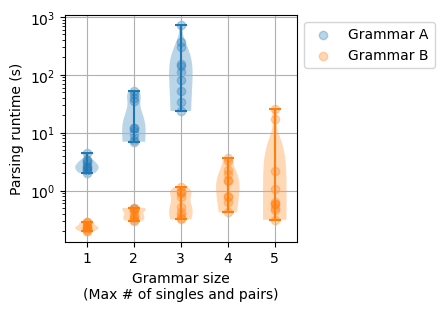

In [90]:
plt.figure(dpi=100).set_size_inches(3, 3)
def plot_with_errorbars(list_of_times, label):
    xs = range(1, len(list_of_times) + 1)
    y = [np.mean(times) for times in list_of_times]
    y_std = [np.std(times) for times in list_of_times]
    parts = plt.violinplot(list_of_times)
    for pc in parts['bodies']:
        c = pc.get_facecolor()
        #pc.set_facecolor(c)
        #pc.set_edgecolor([0., 0., 0., 0])
    for k, (x, times) in enumerate(zip(xs, list_of_times)):
        if k == 0:
            thislabel = label
        else:
            thislabel = None
        plt.scatter(np.repeat(x, len(times)), times, c=c, label=thislabel)
cm = plt.get_cmap("viridis")
con_times = [con_results[k+1][0] for k in range(len(con_results.keys()))]
dep_times = [dep_results[k+1][0] for k in range(len(dep_results.keys()))]
plot_with_errorbars(con_times, "Grammar A")
plot_with_errorbars(dep_times, "Grammar B")
plt.semilogy()
plt.legend(bbox_to_anchor=(1., 1.))
plt.grid(True)
plt.xlabel("Grammar size\n(Max # of singles and pairs)")
plt.ylabel("Parsing runtime (s)")